## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import timm

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

/home/lthpc/.conda/envs/NBEye_image_classification/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define utils

In [2]:

# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    # plt.figure(dpi=300)
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    print(checkpoint.keys())
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(resize_img, img, model, root_dir, name):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.85)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    def tranfer_p(image, title=''):
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        # image is [H, W, 3]
        assert image.shape[2] == 3
        return torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()
    
    fig, axs = plt.subplots(1, 3, dpi=300)
    axs[0].imshow(resize_img)
    axs[0].set_title('Original', fontsize=6)
    axs[0].axis('off')
    resize_img.save(root_dir + name + '_resized.tiff') 
    
    mask_img = tranfer_p(im_masked[0])
    
    axs[1].imshow(tranfer_p(im_masked[0]))
    axs[1].set_title('Masked', fontsize=6)
    axs[1].axis('off')
    mask_image = np.clip(mask_img.detach().cpu().numpy(), 0, 255).astype(np.uint8)
    print(type(mask_image))
    print(mask_image.shape)
    plt.imsave(root_dir + name + '_masked.tiff', mask_image)
    reconstructed_img = tranfer_p(im_paste[0])
    axs[2].imshow(reconstructed_img)
    axs[2].set_title('Reconstructed', fontsize=6)
    axs[2].axis('off')
    reconstructed_image = np.clip(reconstructed_img.detach().cpu().numpy(), 0, 255).astype(np.uint8)
    plt.imsave(root_dir + name + '_reconstructed.tiff', reconstructed_image)
    plt.show()

In [3]:
chkpt_dir = './pretrain_models/mae_ocular_surface_pretrain_75.6w_85mask_800epochs.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

dict_keys(['model', 'optimizer', 'epoch', 'scaler', 'args'])
<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:
<class 'numpy.ndarray'>
(224, 224, 3)


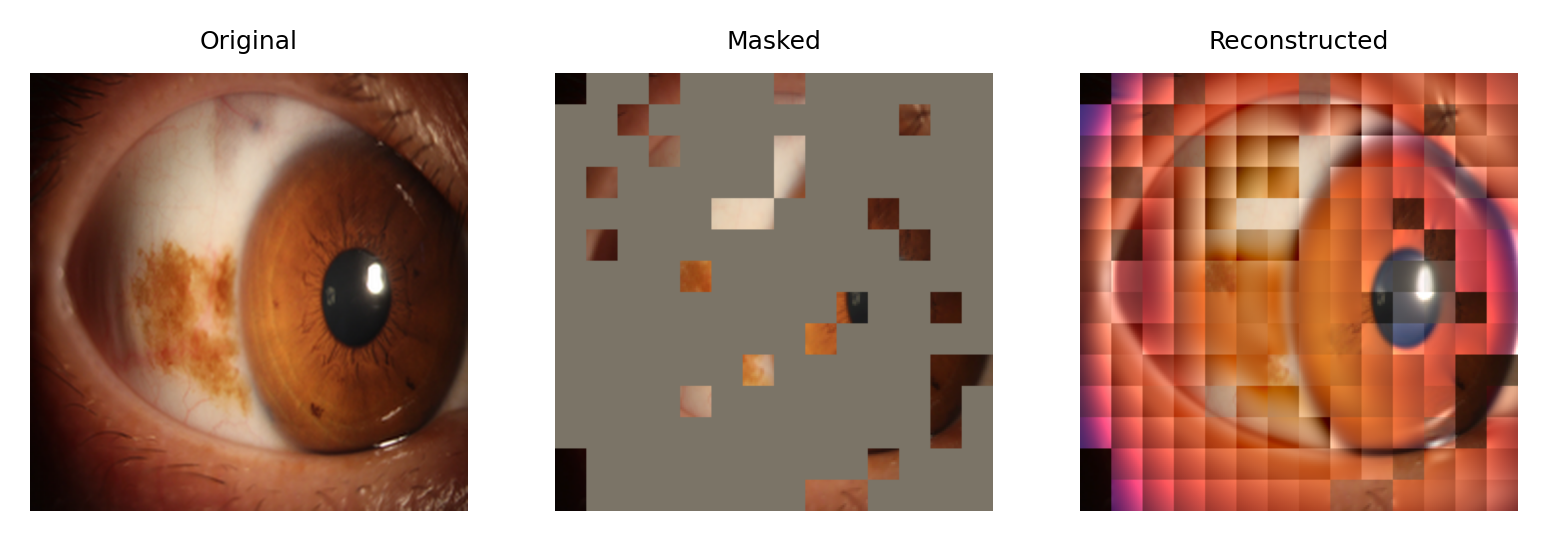

In [4]:
import torchvision.transforms as transforms
import PIL

root_dir = './example_img/'
image_name = 'example_oremalignant.jpg'
name, _ = os.path.splitext(image_name)

img = Image.open(root_dir + image_name)
img = img.resize((224, 224),Image.LANCZOS)
resize_img = img.resize((512, 512),Image.LANCZOS)
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

torch.manual_seed(11)
print('MAE with pixel reconstruction:')
run_one_image(resize_img, img, model_mae, root_dir, name)
